In [41]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
import numpy as np

import camb
from camb import model, initialpower
import pandas as pd

In [51]:
import importlib.util
import sys
spec = importlib.util.spec_from_file_location(
    "spectra", "../shared/spectra.py")
spectra = importlib.util.module_from_spec(spec)
sys.modules["spectra"] = spectra
spec.loader.exec_module(spectra)

In [52]:
omega_index = 1 # while we debug, we confine our attention to just one value
onh2 = spectra.omegas_nu[omega_index]
onh2_str = spectra.omnu_strings[omega_index]

In [53]:
# Axe the 0.01 value since Ariel has not tested that one in the shared results
spectra.omegas_nu = spectra.omegas_nu[:(len(spectra.omegas_nu) - 1)]
spectra.omnu_strings = spectra.omnu_strings[:(len(spectra.omnu_strings) - 1)]
spectra.define_powernu3()

In [5]:
# It's a waste of time to consider all of the omegas and snapshots, so we're
# making heavy use of skips.
spec_sims = spectra.better_battery(spectra.omegas_nu, spectra.omnu_strings,
    skips_omega = [], skips_model=[8], skips_snapshot=[1, 2, 3])

012

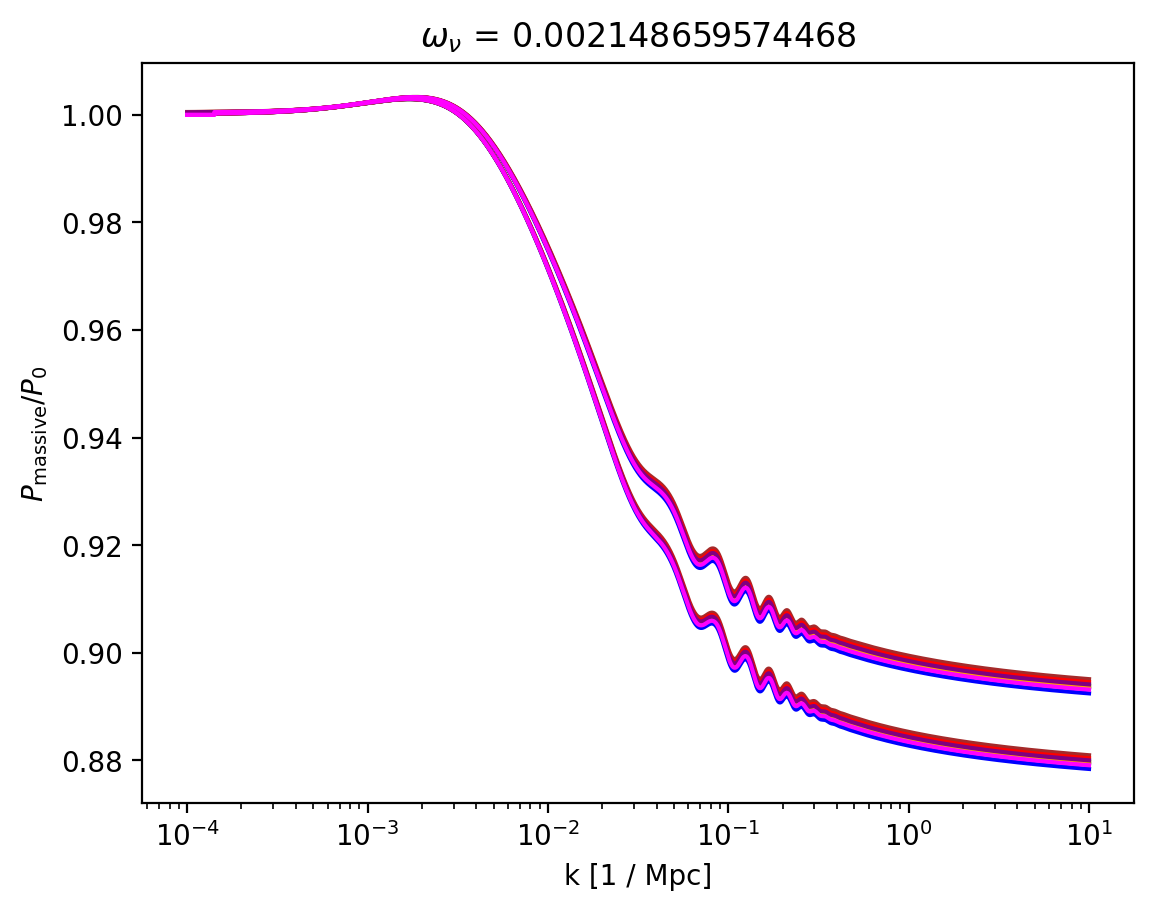

In [6]:
for i in range(len(spec_sims[onh2_str])):
    if spec_sims[onh2_str][i] is None:
        continue
    h = spectra.cosm.loc[i]["h"]
    for j in range(len(spec_sims[onh2_str][i])):
        if spec_sims[onh2_str][i][j] is None:
            continue
        plt.plot(spec_sims[onh2_str][i][j]["k"],
            spec_sims[onh2_str][i][j]["P_nu"] / \
            spec_sims[onh2_str][i][j]["P_no"],
            label="model " + str(i) + ", no renormalizing, z=" + \
            str(spectra.parse_redshifts(i)[j]), c=spectra.colors[i],
            linestyle=spectra.styles[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(onh2))

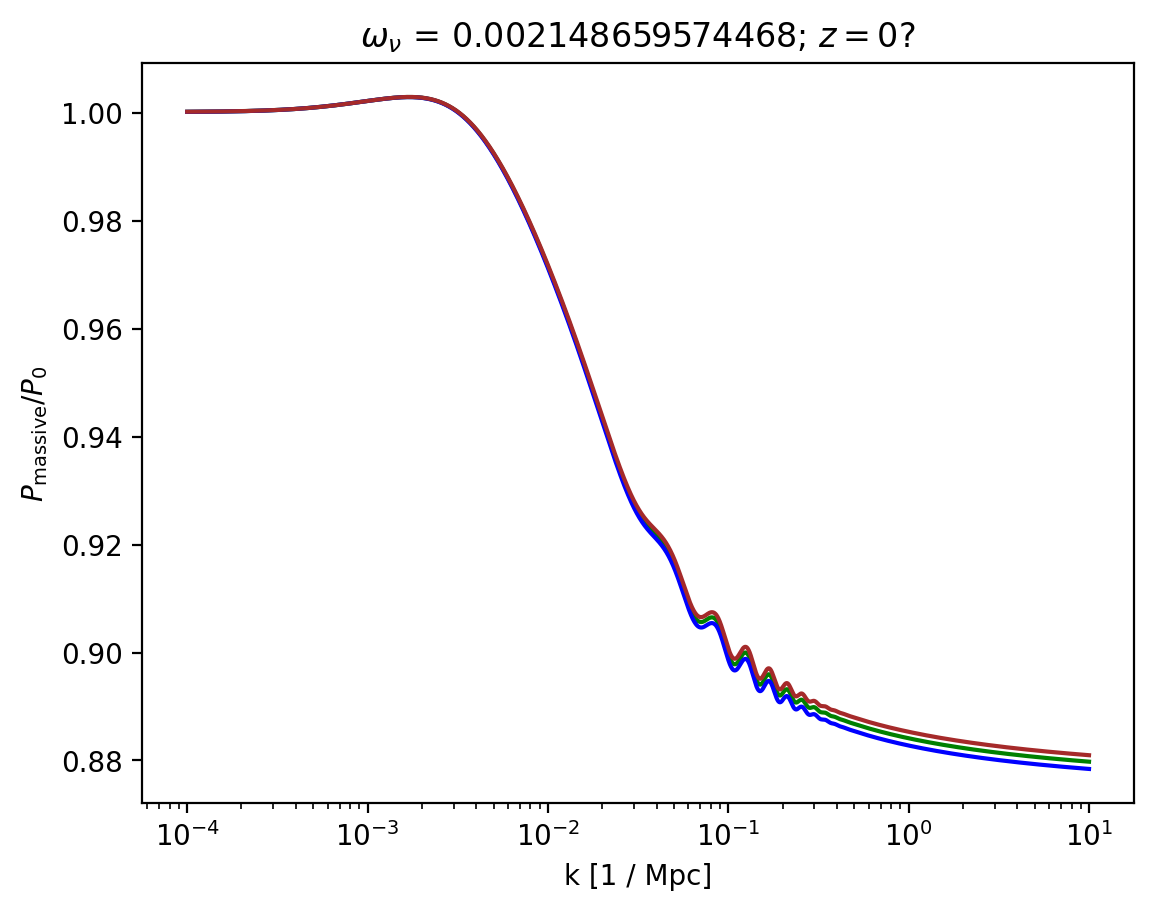

In [7]:
for i in range(0, 3):
    if spec_sims[onh2_str][i] is None:
        continue
    h = spectra.cosm.loc[i]["h"]
    j = 4 # just look at z=0 before moving on
    plt.plot(spec_sims[onh2_str][i][j]["k"],
        spec_sims[onh2_str][i][j]["P_nu"] / \
        spec_sims[onh2_str][i][j]["P_no"],
        label="model " + str(i), c=spectra.colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(onh2) + "; $z=0$?")

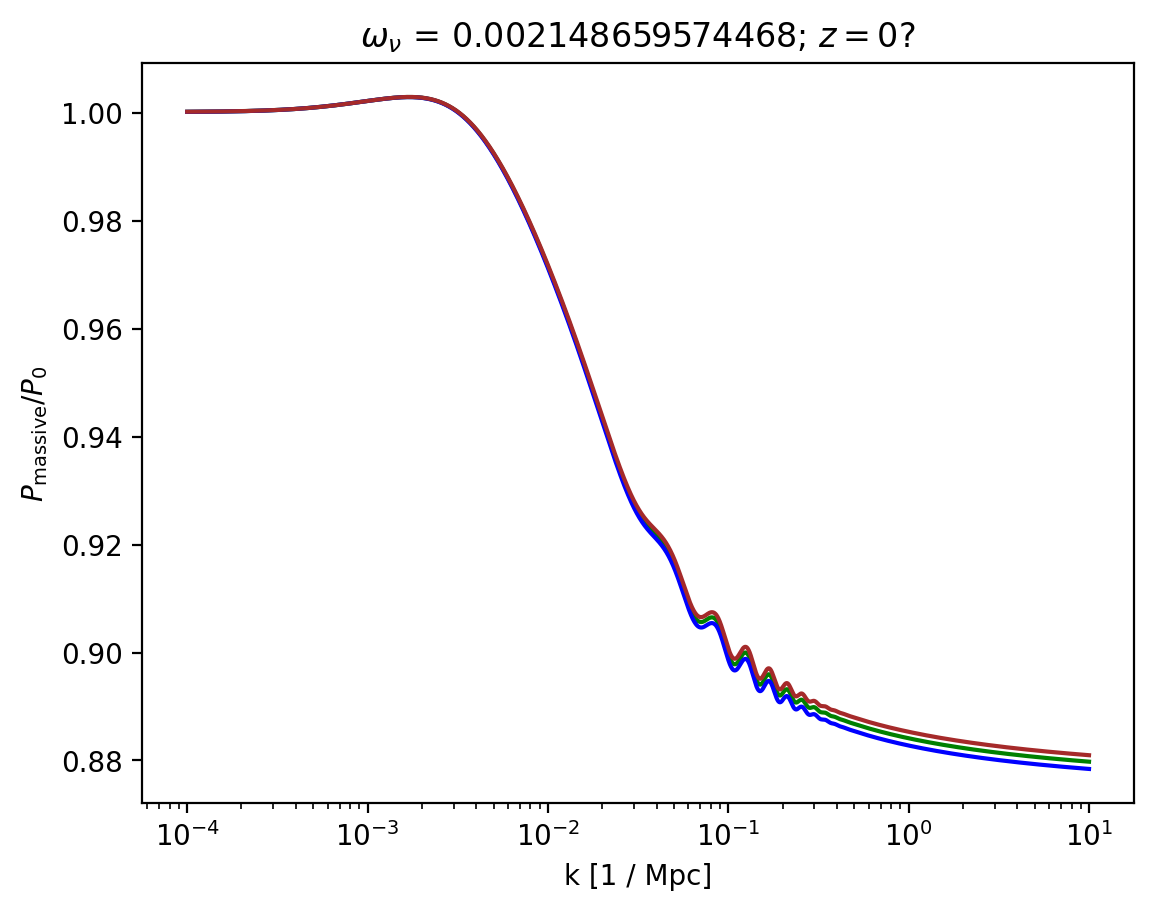

In [8]:
for i in range(0, 3):
    if spec_sims[onh2_str][i] is None:
        continue
    h = spectra.cosm.loc[i]["h"]
    j = 4 # just look at z=0 before moving on
    plt.plot(spec_sims[onh2_str][i][j]["k"],
        spec_sims[onh2_str][i][j]["P_nu"] / \
        spec_sims[onh2_str][i][j]["P_no"],
        label="model " + str(i), c=spectra.colors[i])
    plt.xscale('log')
    plt.xlabel(r"k [1 / Mpc]")
    plt.ylabel(r"$P_\mathrm{massive} / P_0$")
    plt.title(r"$\omega_\nu$ = " + str(onh2) + "; $z=0$?")

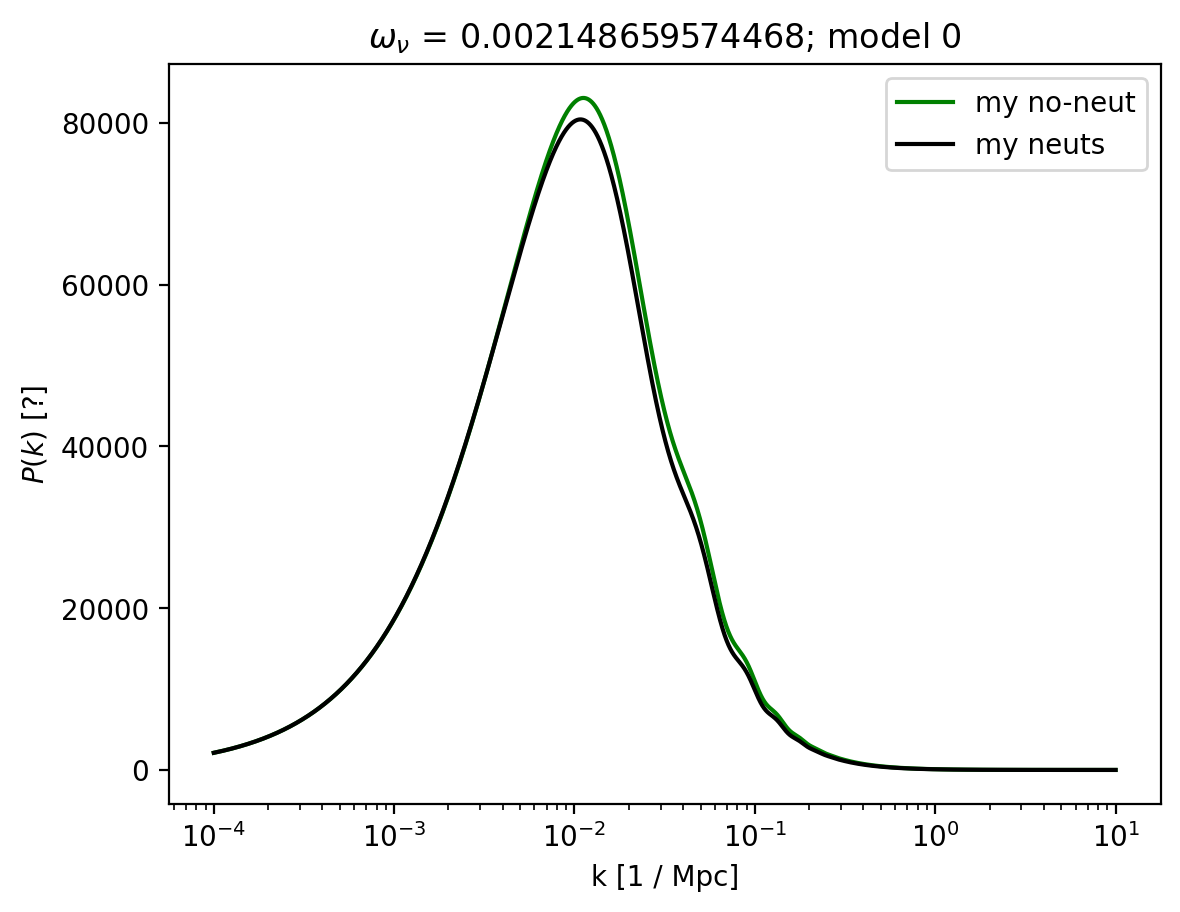

In [9]:
i = 0
h = spectra.cosm.loc[i]["h"]
j = 4
sim = spec_sims[onh2_str][i][j]

plt.plot(sim["k"], sim["P_no"], label="my no-neut", c=spectra.colors[i])
plt.plot(sim["k"], sim["P_nu"], label="my neuts", c="black")
plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P(k)$ [?]")
plt.title(r"$\omega_\nu$ = " + str(onh2) + "; model 0")
plt.legend()

# This protects other cells by avoiding accidental reuse
del i, h, j, sim

In [68]:
i = 5
true3_early = spectra.powernu3[onh2_str][i][0]
true3_late = spectra.powernu3[onh2_str][i][4]
# The following construction makes indexing a little easier later.
true3 = [true3_early, None, None, None, true3_late]

#LCDM = np.load('../../CAKE21/matteos_spectra/LCDM.npy', allow_pickle=True)[0]
#nuCDM = np.load('../../CAKE21/matteos_spectra/nuCDM.npy', allow_pickle=True)[0]

LCDM = np.load('../../CAKE21/matteos_spectra/LCDM_tiny.npy', allow_pickle=True).item()
nuCDM = np.load('../../CAKE21/matteos_spectra/nuCDM_tiny.npy', allow_pickle=True).item()

mimsims = np.load('../../CAKE21/matteos_spectra/mimsims.npy', allow_pickle=True).item()

In [45]:
model0 = {
    'ombh2' : 0.022445,
    'omch2' : 0.120567,
    'n_s' : 0.96,
    'A_s' : 2.12723788013000E-09,
    'h' : 0.67,
    'w0' : -1.00,
    'wa' : 0.00,
    'OmK' : 0.00
}          

model0_zs = [
    2.000000,
    1.000000,
    0.570000,
    0.300000,
    0.000000
]

model0_zs_ends = [
    model0_zs[0],
    model0_zs[len(model0_zs) - 1]
]

def model_i_ends(i):
    zs = spectra.parse_redshifts(i)
    return [max(zs), min(zs)]

omnu_Lukas = 0.002148659574468

Lukas_modeli = 0
Lukas_LCDM = spectra.kzps(spectra.cosm.iloc[Lukas_modeli], omnuh2_in=omnu_Lukas, nu_massive=False,
    zs=model_i_ends(Lukas_modeli))
Lukas_nuCDM = spectra.kzps(spectra.cosm.iloc[Lukas_modeli], omnuh2_in=omnu_Lukas, nu_massive=True,
    zs=model_i_ends(Lukas_modeli))
Lukas_h = spectra.cosm.iloc[Lukas_modeli]['h']

redshifts [2.0, 0.0]
baryon dens 0.022445
cdm dens 0.120567
spec index 0.96
scalar amp 2.1272378801300004e-09
Hubble con 0.67
DE con -1.0
DE slope 0.00
curvie 0.0
redshifts [2.0, 0.0]
baryon dens 0.022445
cdm dens 0.120567
spec index 0.96
scalar amp 2.1272378801300004e-09
Hubble con 0.67
DE con -1.0
DE slope 0.00
curvie 0.0


[1.9726   0.990094 0.566389 0.298893 0.      ]


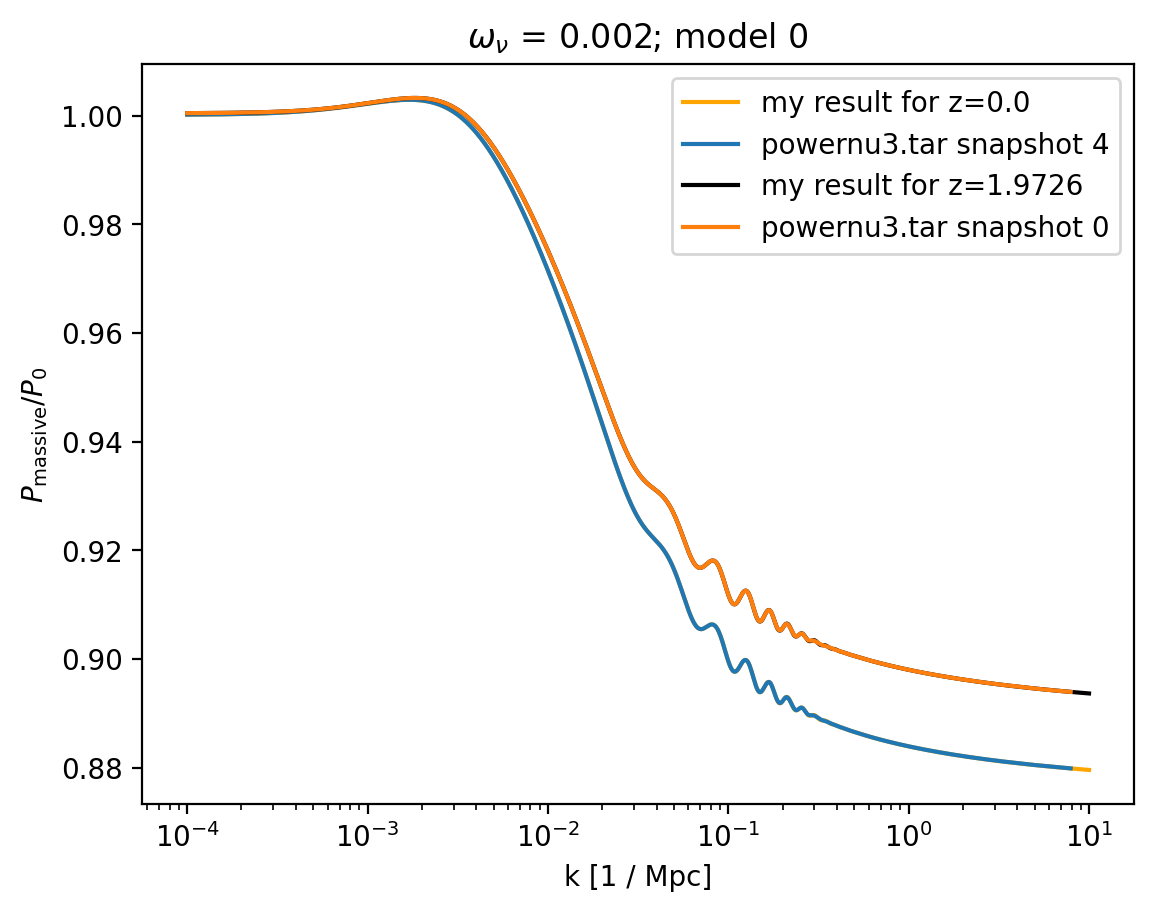

In [69]:
# best case seems to be i = 0
# worst case seems to be i = 1
on_accessor = "0.002"
h = spectra.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = spectra.parse_redshifts(i)

print(z_list)
sim = spec_sims[on_accessor][i][j]

# better_battery access
plt.plot(sim["k"], sim["P_nu"] / sim["P_no"], c=spectra.colors[i],
    label="my result for z=" + str(z_list[j]))
# Ariel's results
plt.plot(true3[j]["k"], true3[j]["ratio"],
         label="powernu3.tar snapshot 4")
# Direct access
#plt.plot(Lukas_LCDM[0] * Lukas_h, Lukas_nuCDM[2][1] / Lukas_LCDM[2][1],
#             label='Lukas direct snap 4'.format(0))
# Maximum mimicry of Matteo's stuff within kzps framework
#plt.plot(mimsims['no']['k'],
#         mimsims['nu']['p'][j] / mimsims['no']['p'][j],
#        label='mimsims snap 4')
# Matteo's results
#plt.plot(LCDM['kk'], nuCDM['Pk'][4] / LCDM['Pk'][4],
#             label='Matteo, snapshot 4?'.format(0))

j = 0 # This will correspond to z=0 for the model0 case.
sim = spec_sims[on_accessor][i][j]

plt.plot(sim["k"], sim["P_nu"] / sim["P_no"], c="black",
    label="my result for z=" + str(z_list[j]))
plt.plot(true3[j]["k"], true3[j]["ratio"],
         label="powernu3.tar snapshot 0")
#plt.plot(Lukas_LCDM[0] * Lukas_h, Lukas_nuCDM[2][0] / Lukas_LCDM[2][0],
#             label='Lukas direct snap 0'.format(0))
#plt.plot(mimsims['no']['k'],
#         mimsims['nu']['p'][j] / mimsims['no']['p'][j],
#        label='mimsims snap 0')
#plt.plot(LCDM['kk'], nuCDM['Pk'][0] / LCDM['Pk'][0],
#             label='Matteo, snapshot 0?'.format(0))

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + onh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del h, j, z_list, sim, on_accessor

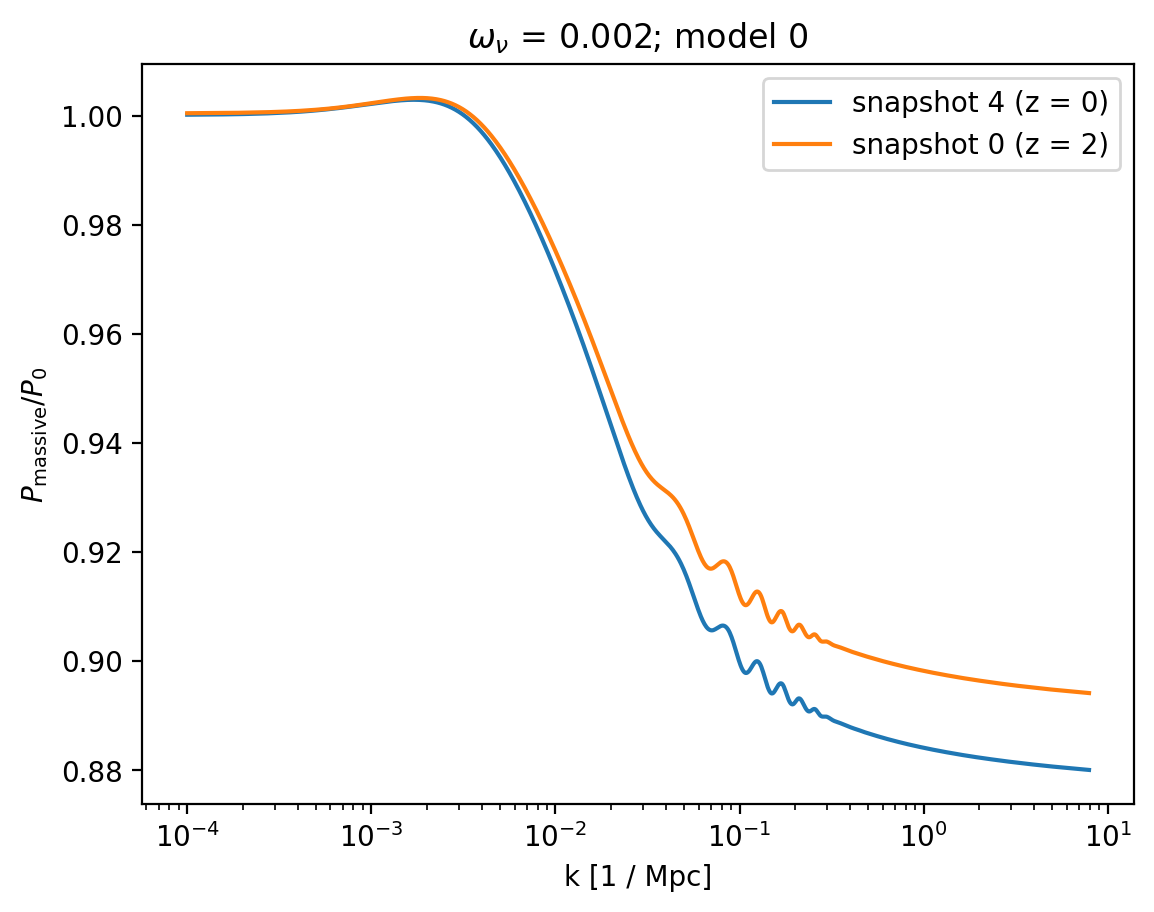

In [36]:
# best case seems to be i = 0
# worst case seems to be i = 1
del i
on_accessor = "0.002"
i = 1
h = spectra.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = spectra.parse_redshifts(i)
sim = spec_sims[on_accessor][i][j]

plt.plot(true3[j]["k"], true3[j]["ratio"],
         label="snapshot 4 (z = 0)")
#plt.plot(Lukas_LCDM[0] * model0['h'], Lukas_nuCDM[2][1] / Lukas_LCDM[2][1],
#             label='Lukas direct snap 4'.format(0))
#plt.plot(LCDM['kk'], nuCDM['Pk'][4] / LCDM['Pk'][4],
#             label='Matteo, snapshot 4?'.format(0))

j = 0 # This will correspond to z=0 for the model0 case.
sim = spec_sims[on_accessor][i][j]

plt.plot(true3[j]["k"], true3[j]["ratio"],
         label="snapshot 0 (z = 2)")
#plt.plot(Lukas_LCDM[0] * model0['h'], Lukas_nuCDM[2][0] / Lukas_LCDM[2][0],
#             label='Lukas direct snap 0'.format(0))
#plt.plot(LCDM['kk'], nuCDM['Pk'][0] / LCDM['Pk'][0],
#             label='Matteo, snapshot 0?'.format(0))

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.title(r"$\omega_\nu$ = " + onh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, sim, on_accessor

The problem has something to do with better_battery. It has nothing to do with evaluating the power spectra at individual redshifts (as opposed to the batch approach used in Matteo's work).

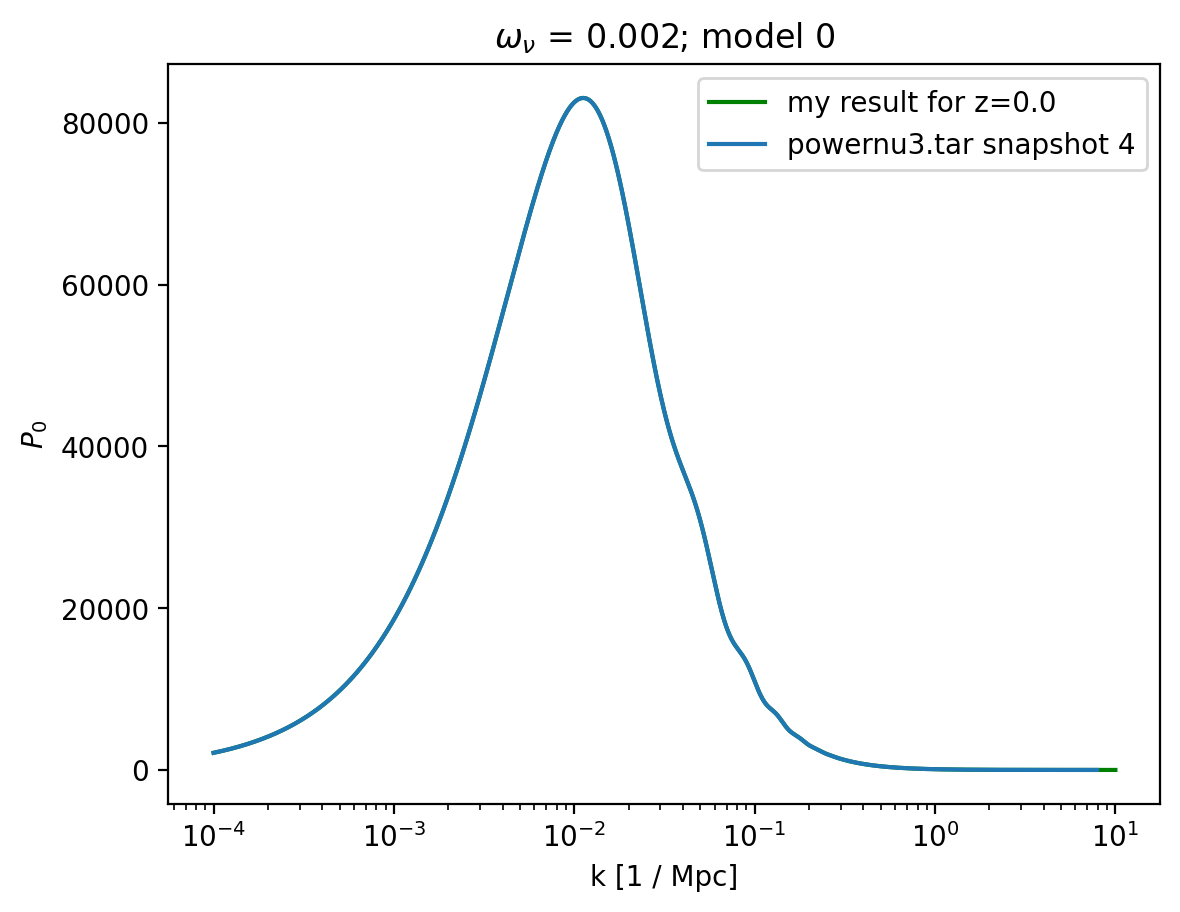

In [16]:
i = 0
h = spectra.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = spectra.parse_redshifts(i)
sim = spec_sims[onh2_str][i][j]

plt.plot(sim["k"], sim["P_no"], c=spectra.colors[i],
    label="my result for z=" + str(sim["z"]))
plt.plot(true3_late["k"], true3_late["P_no"],
         label="powernu3.tar snapshot 4")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_0$")
plt.title(r"$\omega_\nu$ = " + onh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, sim

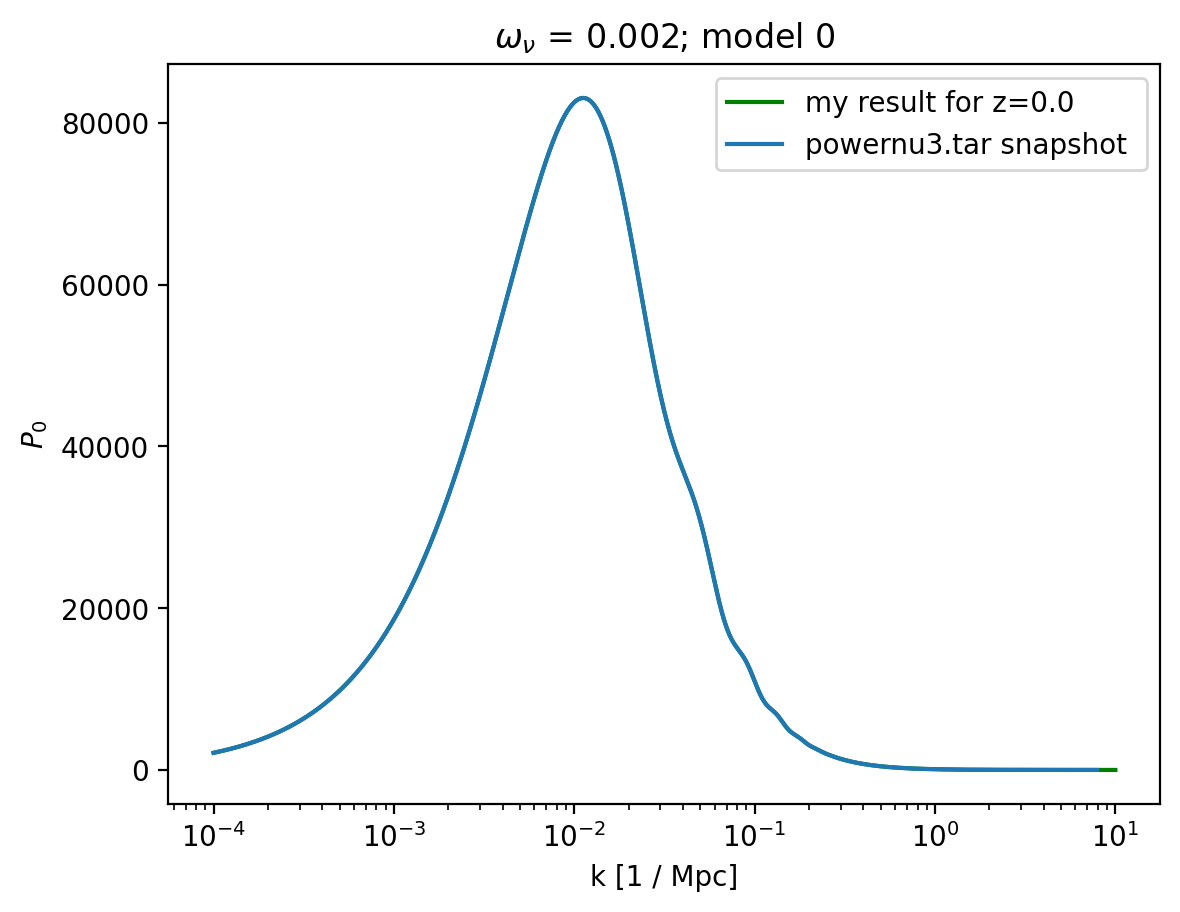

In [17]:
i = 0
h = spectra.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = spectra.parse_redshifts(i)
sim = spec_sims[onh2_str][i][j]

plt.plot(sim["k"], sim["P_no"], c=spectra.colors[i],
    label="my result for z=" + str(sim["z"]))
plt.plot(true3_late["k"], true3_late["P_no"],
         label="powernu3.tar snapshot ")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_0$")
plt.title(r"$\omega_\nu$ = " + onh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, sim

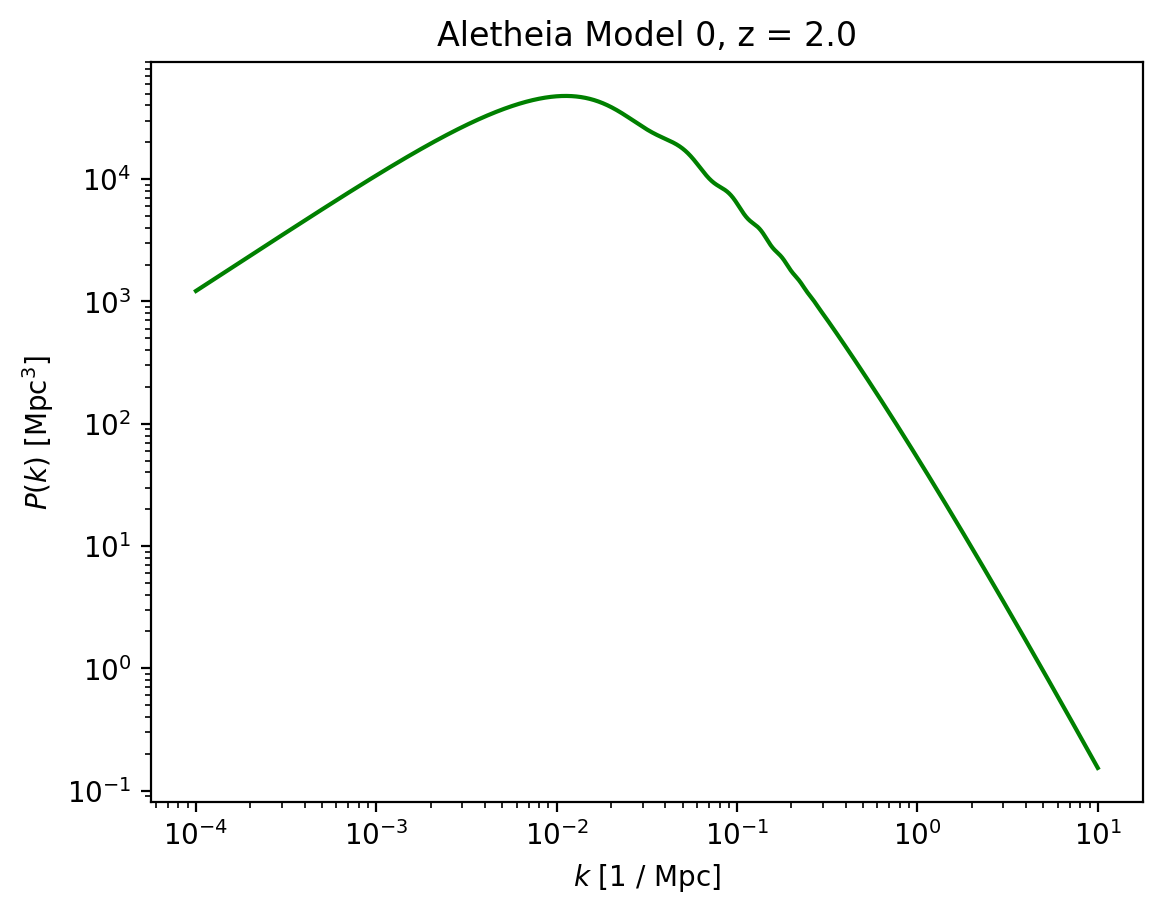

In [18]:
i = 0
h = spectra.cosm.loc[i]["h"]
j = 0 # this should be SNAP index, not z index
z_list = spectra.parse_redshifts(i)
sim = spec_sims[onh2_str][i][j]

plt.plot(sim["k"], sim["P_no"] / 0.67 ** 3, c=spectra.colors[i])

plt.xscale('log')
plt.xlabel(r"$k$ [1 / Mpc]")
plt.ylabel(r"$P(k)$ [Mpc$^3$]")
plt.yscale('log')
plt.title(r"Aletheia Model 0, z = 2.0")
#plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, sim

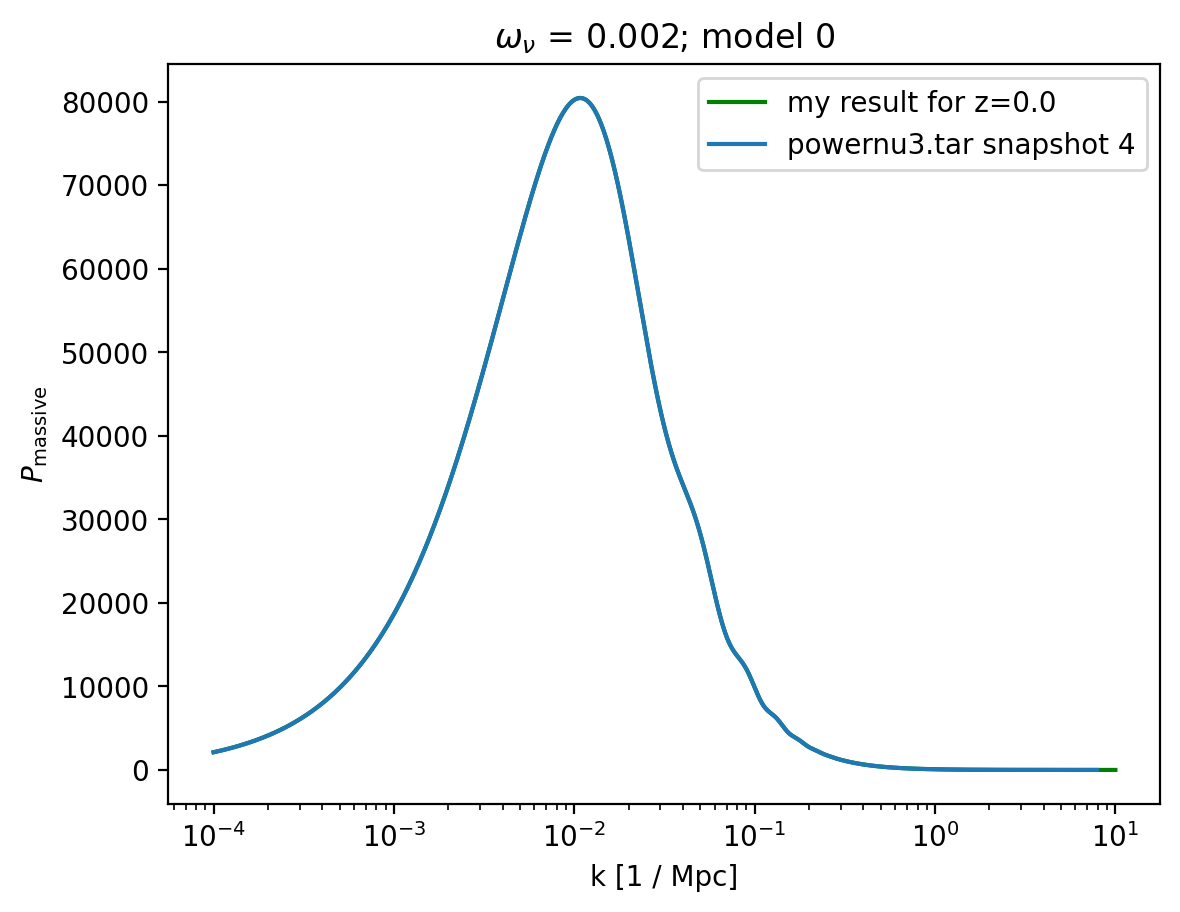

In [19]:
i = 0
h = spectra.cosm.loc[i]["h"]
j = 4 # this should be SNAP index, not z index
z_list = spectra.parse_redshifts(i)
sim = spec_sims[onh2_str][i][j]

plt.plot(sim["k"], sim["P_nu"], c=spectra.colors[i],
    label="my result for z=" + str(sim["z"]))
plt.plot(true3_late["k"], true3_late["P_nu"],
         label="powernu3.tar snapshot 4")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive}$")
plt.title(r"$\omega_\nu$ = " + onh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, sim

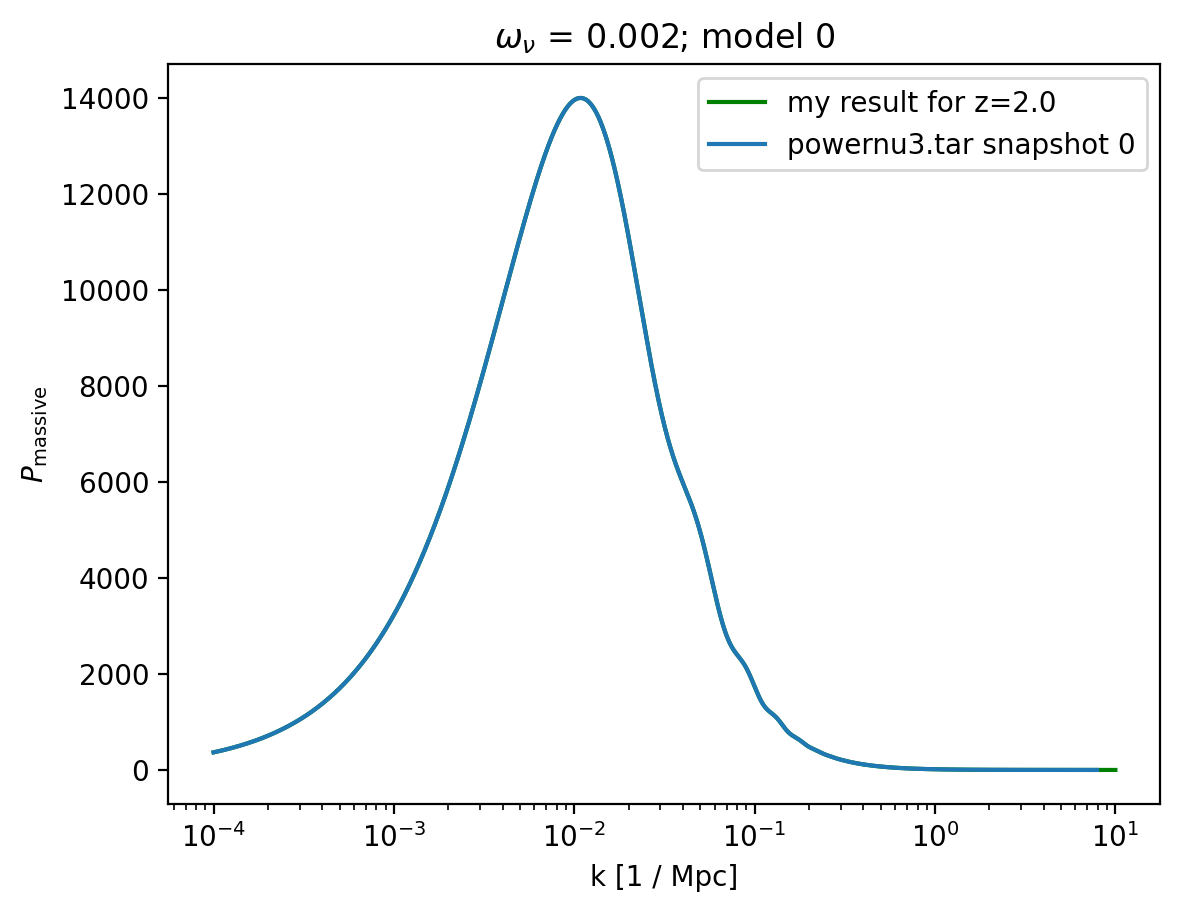

In [20]:
i = 0
h = spectra.cosm.loc[i]["h"]
j = 0 # this should be SNAP index, not z index
z_list = spectra.parse_redshifts(i)
sim = spec_sims[onh2_str][i][j]

plt.plot(sim["k"], sim["P_nu"], c=spectra.colors[i],
    label="my result for z=" + str(sim["z"]))
plt.plot(true3_early["k"], true3_early["P_nu"],
         label="powernu3.tar snapshot 0")

plt.xscale('log')
plt.xlabel(r"k [1 / Mpc]")
plt.ylabel(r"$P_\mathrm{massive}$")
plt.title(r"$\omega_\nu$ = " + onh2_str + "; model 0")
plt.legend()

# This protects other cells by avoiding unintended reuse
del i, h, j, z_list, sim